In [129]:
import torch
from config import LatticeGeneration, GNN
from utils import *
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import tqdm
from matplotlib import pyplot as plt

# Process MI Scores

In [228]:
data_path = 'RealWorldData/'
dataset_name = 'mobile'

In [229]:
def read_dataset_and_lattice(data_path, dataset_name, edgeSamplingRatio=0.5):
    with open(f"{data_path}{dataset_name}/dataset.pkl", "rb") as f:
        dataset_df = pickle.load(f)
    lattice_graph = torch.load(f"{data_path}{dataset_name}/dataset_hetero_graph_edgeSamplingRatio={edgeSamplingRatio}.pt")
    return dataset_df, lattice_graph    

In [230]:
dataset_df, lattice_graph = read_dataset_and_lattice(data_path, dataset_name)

In [231]:
feature_num = lattice_graph['g0'].x.shape[1]
subgroups = lattice_graph.node_types
feature_names = [f'f_{i}'for i in range(feature_num)]
min_m = LatticeGeneration.min_m
max_m = LatticeGeneration.max_m
num_layers = GNN.num_layers
min_level = get_min_level(min_m, num_layers)
max_level = get_max_level(max_m, num_layers, feature_num)
comb_size = 3

In [232]:
lattice_graph['g0'].x.shape[0]

22818

In [233]:
def get_restricted_graph_idxs_mapping(feature_num, min_level, max_level):
    binary_vecs = [convert_decimal_to_binary(i + 1, feature_num) for i in range(2 ** feature_num - 1)]
    rel_nid = [i for i, binary_vec in enumerate(binary_vecs) if min_level <= binary_vec.count('1') <= max_level]
    return {orig_nid: new_nid for new_nid, orig_nid in enumerate(rel_nid)}

def binary_to_feature_comb(binary, feature_names, feature_num):
    return [feature_names[feature_num-i-1] for i in range(len(binary)) if binary[i] == '1']


def convert_decimal_to_binary(decimal, feature_num):
    binary = bin(decimal)[2:]
    return '0' * (feature_num - len(binary)) + binary


def create_decimal_to_comb_dict(restricted_graph_indices, feature_num, feature_names):
    decimal_to_comb_dict = dict()
    for orig_nid, new_nid in restricted_graph_indices.items():
        binary_vec = convert_decimal_to_binary(orig_nid + 1, feature_num)
        comb = binary_to_feature_comb(binary_vec, feature_names, feature_num)
        decimal_to_comb_dict[new_nid] = comb
    return decimal_to_comb_dict

def get_comb_size_indices(restricted_graph_indices, feature_num, comb_sizes):
    comb_indices_dict = {comb_size: [] for comb_size in comb_sizes}
    for orig_nid, new_nid in restricted_graph_indices.items():
        binary_vec = convert_decimal_to_binary(orig_nid+1, feature_num)
        if binary_vec.count('1') in comb_sizes:
            comb_indices_dict[binary_vec.count('1')].append(new_nid)
    return comb_indices_dict


restricted_graph_indices = get_restricted_graph_idxs_mapping(feature_num, min_level, max_level)
decimal_to_comb_dict = create_decimal_to_comb_dict(restricted_graph_indices, feature_num, feature_names)
comb_indices_dict = get_comb_size_indices(restricted_graph_indices, feature_num, comb_sizes)

In [234]:
def print_top_k_combs(comb_indices_dict, comb_size, subgroups, k):
    for subgroup in subgroups:
        rel_idxs = comb_indices_dict[comb_size]
        labels = lattice_graph[subgroup].y
        # sort labels in descending order
        sorted_idxs = torch.argsort(labels, descending=True)
        top_k_combinations = [(decimal_to_comb_dict[idx.item()], labels[idx.item()]) for idx in sorted_idxs if idx.item() in rel_idxs][:k]
        print(f"Subgroup {subgroup}")
        for idx, comb_label in enumerate(top_k_combinations):
            comb = comb_label[0]
            # print(comb_label)
            # print(comb_label[0])
            label = comb_label[1].item()
            print(f"Top {idx+1} combination: {comb}, label: {round(label, 6)}")
        print("\n")

In [235]:
print_top_k_combs(comb_indices_dict, 3, subgroups, 20)

Subgroup g0
Top 1 combination: ['f_12', 'f_4', 'f_3'], label: 1.342497
Top 2 combination: ['f_14', 'f_4', 'f_2'], label: 1.342497
Top 3 combination: ['f_14', 'f_6', 'f_1'], label: 1.337537
Top 4 combination: ['f_14', 'f_8', 'f_6'], label: 1.337191
Top 5 combination: ['f_14', 'f_1', 'f_0'], label: 1.336311
Top 6 combination: ['f_14', 'f_6', 'f_2'], label: 1.328178
Top 7 combination: ['f_12', 'f_10', 'f_0'], label: 1.321361
Top 8 combination: ['f_12', 'f_5', 'f_4'], label: 1.318286
Top 9 combination: ['f_14', 'f_7', 'f_0'], label: 1.317912
Top 10 combination: ['f_12', 'f_5', 'f_0'], label: 1.316873
Top 11 combination: ['f_14', 'f_5', 'f_0'], label: 1.31634
Top 12 combination: ['f_12', 'f_8', 'f_0'], label: 1.314393
Top 13 combination: ['f_12', 'f_8', 'f_3'], label: 1.313514
Top 14 combination: ['f_13', 'f_12', 'f_9'], label: 1.311193
Top 15 combination: ['f_14', 'f_9', 'f_1'], label: 1.309434
Top 16 combination: ['f_12', 'f_7', 'f_2'], label: 1.3089
Top 17 combination: ['f_14', 'f_5', 'f

In [236]:
def get_comb_MI_score(comb_indices_dict, comb_size, subgroups):
    comb_MI_dict = {subgroup: defaultdict(dict) for subgroup in subgroups}
    for subgroup in subgroups:
        rel_idxs = comb_indices_dict[comb_size]
        labels = lattice_graph[subgroup].y
        for idx in rel_idxs:
            comb = decimal_to_comb_dict[idx]
            comb_MI_dict[subgroup][tuple(comb)]['MI'] = labels[idx].item()
    return comb_MI_dict

In [237]:
comb_MI_dict = get_comb_MI_score(comb_indices_dict, 3, subgroups)

In [238]:
comb_MI_dict

{'g0': defaultdict(dict,
             {('f_2', 'f_1', 'f_0'): {'MI': 0.0605820007622242},
              ('f_3', 'f_1', 'f_0'): {'MI': 0.05733200162649155},
              ('f_3', 'f_2', 'f_0'): {'MI': 0.07245299965143204},
              ('f_3', 'f_2', 'f_1'): {'MI': 0.021261999383568764},
              ('f_4', 'f_1', 'f_0'): {'MI': 0.046528998762369156},
              ('f_4', 'f_2', 'f_0'): {'MI': 0.06174999848008156},
              ('f_4', 'f_2', 'f_1'): {'MI': 0.02153100073337555},
              ('f_4', 'f_3', 'f_0'): {'MI': 0.060210999101400375},
              ('f_4', 'f_3', 'f_1'): {'MI': 0.015994999557733536},
              ('f_4', 'f_3', 'f_2'): {'MI': 0.027758000418543816},
              ('f_5', 'f_1', 'f_0'): {'MI': 0.06133300065994263},
              ('f_5', 'f_2', 'f_0'): {'MI': 0.08296900242567062},
              ('f_5', 'f_2', 'f_1'): {'MI': 0.027096999809145927},
              ('f_5', 'f_3', 'f_0'): {'MI': 0.07656099647283554},
              ('f_5', 'f_3', 'f_1'): {'MI': 0.

In [239]:
decimal_to_comb_dict[2]

['f_1', 'f_0']

# Process dataset

In [240]:
dataset_df_subgroup = dataset_df[dataset_df['subgroup'] == 0]

In [241]:
comb_MI_dict

{'g0': defaultdict(dict,
             {('f_2', 'f_1', 'f_0'): {'MI': 0.0605820007622242},
              ('f_3', 'f_1', 'f_0'): {'MI': 0.05733200162649155},
              ('f_3', 'f_2', 'f_0'): {'MI': 0.07245299965143204},
              ('f_3', 'f_2', 'f_1'): {'MI': 0.021261999383568764},
              ('f_4', 'f_1', 'f_0'): {'MI': 0.046528998762369156},
              ('f_4', 'f_2', 'f_0'): {'MI': 0.06174999848008156},
              ('f_4', 'f_2', 'f_1'): {'MI': 0.02153100073337555},
              ('f_4', 'f_3', 'f_0'): {'MI': 0.060210999101400375},
              ('f_4', 'f_3', 'f_1'): {'MI': 0.015994999557733536},
              ('f_4', 'f_3', 'f_2'): {'MI': 0.027758000418543816},
              ('f_5', 'f_1', 'f_0'): {'MI': 0.06133300065994263},
              ('f_5', 'f_2', 'f_0'): {'MI': 0.08296900242567062},
              ('f_5', 'f_2', 'f_1'): {'MI': 0.027096999809145927},
              ('f_5', 'f_3', 'f_0'): {'MI': 0.07656099647283554},
              ('f_5', 'f_3', 'f_1'): {'MI': 0.

In [242]:
dataset_df_subgroup[list(('f_14', 'f_12', 'f_11', 'y'))]

,f_14,f_12,f_11,y
0,1,0,1,1
3,0,1,0,2
4,0,1,1,1
6,1,1,1,3
8,0,1,1,0
...,...,...,...,...
1990,0,1,0,0
1991,0,1,1,3
1993,1,1,0,3
1994,0,1,0,3


In [243]:
dataset_df_subgroup['y']

0       1
3       2
4       1
6       3
8       0
       ..
1990    0
1991    3
1993    3
1994    3
1998    0
Name: y, Length: 981, dtype: int64

In [244]:
dataset_df_subgroup['y'].value_counts()

y
2    251
0    250
1    245
3    235
Name: count, dtype: int64

In [247]:
def get_comb_downstream_accuracy(comb_MI_dict, subgroup, dataset_df_subgroup, model):
    train_idx = np.random.choice(len(dataset_df_subgroup), int(0.7 * len(dataset_df_subgroup)), replace=False)
    test_idx = np.array(list(set(range(len(dataset_df_subgroup))) - set(train_idx)))
    y = np.array(dataset_df_subgroup['y'])
    for comb in tqdm.tqdm(comb_MI_dict[subgroup].keys()):
        x = np.array(dataset_df_subgroup[list(comb)])
        model.fit(x[train_idx], y[train_idx])
        predictions = model.predict(x[test_idx])
        # get f1 score
        accuracy = np.mean(predictions == y[test_idx])
        comb_MI_dict[subgroup][comb]['accuracy'] = accuracy
    return comb_MI_dict

In [262]:
comb_MI_dict = get_comb_downstream_accuracy(comb_MI_dict, 'g0', dataset_df_subgroup, LogisticRegression())

100%|██████████| 455/455 [00:02<00:00, 211.01it/s]


In [263]:
def generate_scatter_plot(comb_MI_dict, subgroup, comb_size):
    x = [comb_MI_dict[subgroup][comb]['MI'] for comb in comb_MI_dict[subgroup].keys()]
    y = [comb_MI_dict[subgroup][comb]['f1'] for comb in comb_MI_dict[subgroup].keys()]
    plt.scatter(x, y)
    plt.xlabel("MI")
    plt.ylabel("Accuracy")
    plt.title(f"Subgroup {subgroup}, Combination Size {comb_size}")
    plt.show()

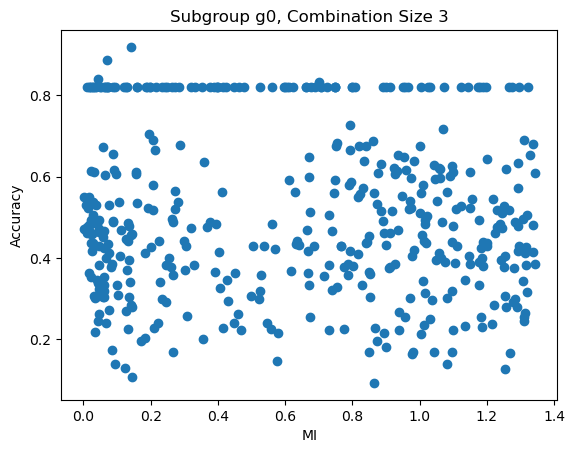

In [264]:
generate_scatter_plot(comb_MI_dict, 'g0', 3)

In [257]:
comb_MI_dict

{'g0': defaultdict(dict,
             {('f_2', 'f_1', 'f_0'): {'MI': 0.0605820007622242,
               'f1': 0.33333333333333337,
               'accuracy': 0.2983050847457627},
              ('f_3', 'f_1', 'f_0'): {'MI': 0.05733200162649155,
               'f1': 0.3050847457627119,
               'accuracy': 0.29152542372881357},
              ('f_3', 'f_2', 'f_0'): {'MI': 0.07245299965143204,
               'f1': 0.43333333333333335,
               'accuracy': 0.3016949152542373},
              ('f_3', 'f_2', 'f_1'): {'MI': 0.021261999383568764,
               'f1': 0.45945945945945943,
               'accuracy': 0.28135593220338984},
              ('f_4', 'f_1', 'f_0'): {'MI': 0.046528998762369156,
               'f1': 0.463768115942029,
               'accuracy': 0.28135593220338984},
              ('f_4', 'f_2', 'f_0'): {'MI': 0.06174999848008156,
               'f1': 0.31999999999999995,
               'accuracy': 0.3254237288135593},
              ('f_4', 'f_2', 'f_1'): {'MI': 

In [259]:
dataset_df_subgroup[list(('f_14', 'f_13', 'f_7'))]

,f_14,f_13,f_7
0,1,0,0
3,0,0,0
4,0,1,1
6,1,0,0
8,0,0,1
...,...,...,...
1990,0,0,0
1991,0,1,1
1993,1,1,0
1994,0,1,0


In [260]:
np.array(dataset_df_subgroup[list(('f_14', 'f_13', 'f_7'))])

array([[1, 0, 0],
       [0, 0, 0],
       [0, 1, 1],
       ...,
       [1, 1, 0],
       [0, 1, 0],
       [1, 1, 0]], dtype=int64)

In [261]:
np.array([[1, 2, 3], [4, 5, 6]])

array([[1, 2, 3],
       [4, 5, 6]])